In [3]:
import pandas as pd
import numpy as np
import gc
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from scipy import sparse
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc, accuracy_score

%matplotlib inline

Using TensorFlow backend.
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [4]:
dftrain = pd.read_csv('datasources/jigsaw1/train.csv').fillna(' ')
dftest = pd.read_csv('datasources/jigsaw1/test.csv').fillna(' ')

traincomments = dftrain['comment_text']
testcomments = dftest['comment_text']
wikicomments = pd.concat([traincomments, testcomments])

wikicomments = wikicomments
print('train : {}'.format(traincomments.shape))
print('test  : {}'.format(testcomments.shape))
print('train + test : {}'.format(wikicomments.shape))

train : (159571,)
test  : (153164,)
train + test : (312735,)


In [5]:
dftest['comment_text'].sample(10)

107657    ==Fuck You== \n If you dont accept the faceboo...
152463    " \n\n ==Bobby Sands== \n\n Thanks. I apprecia...
90615     Pewep, a zSilencer proprietor, continues to is...
140845    == Ok == \n\n I was just testing to see how qu...
43531     YOU People are stupid fuuuck am I annoying com...
110906    Please stop adding nonsense to Wikipedia.  It ...
121480    == project invite == \n\n Hi Shaun, I'm messag...
108049                             I am awesome so suck it.
32727     " \n\n == GAY! == \n\n I LOVE TEH TOUCHING PEN...
136380    :::Rick, you always have a way of putting thin...
Name: comment_text, dtype: object

### Analyse par  tfidf: TfidfVectorizer =  CountVectorizer + TfidfTransformer.

In [6]:
vect_word = TfidfVectorizer(max_features=20000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)

In [7]:
# Word ngram vector
train_vect = vect_word.fit_transform(dftrain['comment_text'])
test_vect = vect_word.transform(dftest['comment_text'])

In [8]:
train_vect.shape

(159571, 20000)

In [9]:
print(len(vect_word.get_feature_names()))

20000


In [10]:
vect_char = TfidfVectorizer(max_features=40000, lowercase=True, analyzer='char',
                        stop_words= 'english',ngram_range=(3,6),dtype=np.float32)

In [11]:
# Character n gram vector
tr_vect_char = vect_char.fit_transform(dftrain['comment_text'])
ts_vect_char = vect_char.transform(dftest['comment_text'])

In [12]:
vect_char.get_feature_names()

['\n""',
 '\nan',
 '\nbu',
 '\nhe',
 '\nhel',
 '\nhi',
 '\nho',
 '\nhow',
 '\nhow ',
 '\nhow t',
 '\nht',
 '\nhtt',
 '\nhttp',
 '\nhttp:',
 '\ni ',
 '\ni a',
 '\ni h',
 "\ni'",
 '\nif',
 '\nif ',
 '\nin',
 '\nit',
 '\nma',
 '\nno',
 '\npl',
 '\nple',
 '\nplea',
 '\npleas',
 '\nso',
 '\nth',
 '\ntha',
 '\nthan',
 '\nthank',
 '\nthe',
 '\nthe ',
 '\nthe f',
 '\nthi',
 '\nthis',
 '\nthis ',
 '\nwe',
 '\nwh',
 '\nwi',
 '\nyo',
 '\nyou',
 '\nyou ',
 '\n|-',
 ' ""',
 ' "" ',
 ' ""a',
 ' ""an',
 ' ""b',
 ' ""c',
 ' ""co',
 ' ""con',
 ' ""d',
 ' ""de',
 ' ""di',
 ' ""e',
 ' ""f',
 ' ""g',
 ' ""h',
 ' ""i',
 ' ""in',
 ' ""j',
 ' ""l',
 ' ""m',
 ' ""ma',
 ' ""n',
 ' ""no',
 ' ""o',
 ' ""p',
 ' ""pr',
 ' ""r',
 ' ""re',
 ' ""s',
 ' ""se',
 ' ""so',
 ' ""t',
 ' ""th',
 ' ""the',
 ' ""u',
 ' ""un',
 ' ""v',
 ' ""w',
 ' ""wh',
 ' ""y',
 ' & ',
 " ''",
 " '''",
 " ''''",
 " '''''",
 " 'c",
 " 'i",
 " 's",
 ' ( ',
 ' (1',
 ' (19',
 ' (2',
 ' (a',
 ' (al',
 ' (an',
 ' (and',
 ' (and ',
 ' (as',
 ' (as 

In [13]:
train_vect.shape, tr_vect_char.shape

((159571, 20000), (159571, 40000))

In [14]:
X = sparse.hstack([train_vect, tr_vect_char])

In [15]:
x_test = sparse.hstack([test_vect, ts_vect_char])

In [28]:
#target_col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
target_col = ['toxic']
y = dftrain[target_col]
y.head()

,toxic
0,0
1,0
2,0
3,0
4,0


In [15]:
print(x_test.shape[0])
print(y.shape[1])
print(np.zeros((x_test.shape[0],y.shape[1])))

153164
1
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [ ]:
#prd = np.zeros((x_test.shape[0],y.shape[1]))
cv_score =[]
    #training 
lr = LogisticRegression(C=2,random_state = 42,class_weight = 'balanced')
print('Column:{''}'.format("toxic")) 
lr.fit(X,y["toxic"])
    
# prédiction
pred =  lr.predict(X)

pred_pro = lr.predict_proba(X)[:,1]


In [ ]:
pred_test =  lr.predict(x_test)

In [ ]:
accuracy_score(y,pred)

In [ ]:
lr.predict_proba(X)

In [ ]:
#prd = np.zeros((x_test.shape[0],y.shape[1]))
cv_score =[]
for i,col in enumerate(target_col):
    #training 
    lr = LogisticRegression(C=2,random_state = 42,class_weight = 'balanced')
    print('Column:{''}'.format(col)) 
    lr.fit(X,y[col])
    
    # prédiction
    pred =  lr.predict(X)
    print('\nConfusion matrix\n',confusion_matrix(y[col],pred))
    print('\nclassification_report\n', classification_report(y[col],pred))
    
    # ROC
    pred_pro = lr.predict_proba(X)[:,1]
    frp,trp,thres = roc_curve(y[col],pred_pro)
    auc_val =auc(frp,trp)
    plt.figure(figsize=(5,3))
    plt.plot([0,1],[0,1],color='b')
    
    plt.plot(frp,trp,color='r',label= 'AUC = %.2f'%auc_val)
    plt.legend(loc='lower right')
    plt.xlabel('True positive rate')
    plt.ylabel('False positive rate')
    plt.title('ROC : {}'.format(col))

In [ ]:
prd

In [ ]:
#del train_vect, test_vect, tr_vect_char, ts_vect_char
#gc.collect()

In [ ]:
for col in target_col:
    print(100 * '=')
    print("Column:",col)
    pred =  lr.predict(X)
    print('\nConfusion matrix\n',confusion_matrix(y[col],pred))
    print('\nclassification_report\n', classification_report(y[col],pred))
    

In [ ]:
for col in target_col:    
    pred_pro = lr.predict_proba(X)[:,1]
    frp,trp,thres = roc_curve(y[col],pred_pro)
    auc_val =auc(frp,trp)
    plt.figure(figsize=(5,3))
    plt.plot([0,1],[0,1],color='b')
    
    plt.plot(frp,trp,color='r',label= 'AUC = %.2f'%auc_val)
    plt.legend(loc='lower right')
    plt.xlabel('True positive rate')
    plt.ylabel('False positive rate')
    plt.title('ROC : {}'.format(col))

In [ ]:
prd_1 = pd.DataFrame(prd,columns=y.columns)
submit = pd.concat([dftest['id'],prd_1],axis=1)
#submit.to_csv('toxic_lr.csv.gz',compression='gzip',index=False)
#submit.to_csv('toxic_lr.csv',index=False)
submit.head(10)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size = 0.3,
                                                   stratify= y,
                                                   random_state=0)

In [29]:
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import cross_val_score

In [30]:
random_state = 40
classifiers = []
#classifiers.append(SVC(random_state=random_state))
#classifiers.append(DecisionTreeClassifier(random_state=random_state))
#classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(MultinomialNB())

In [31]:

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, 
                                     X_train,
                                     np.ravel(y_train),
                                     scoring='accuracy',
                                     cv=3,
                                     n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [32]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means, 
                       "CrossValErros":cv_std,
                      "Algorithm": [
                                   "Logistic Reg",
                                   "Random Forest",
                                   "Naive Bayes"]})


In [33]:
cv_res

,CrossValMeans,CrossValErros,Algorithm
0,0.959525,0.000628,Logistic Reg
1,0.949838,0.000521,Random Forest
2,0.945371,0.000918,Naive Bayes


Text(0.5, 1.0, 'Cross Val Scores')

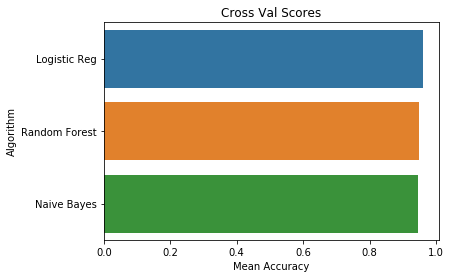

In [34]:
import seaborn as sns
g = sns.barplot("CrossValMeans", "Algorithm", data = cv_res)
g.set_xlabel("Mean Accuracy")
g.set_title("Cross Val Scores")

In [35]:
cv_res.sort_values("CrossValMeans")

,CrossValMeans,CrossValErros,Algorithm
2,0.945371,0.000918,Naive Bayes
1,0.949838,0.000521,Random Forest
0,0.959525,0.000628,Logistic Reg


In [42]:
votingC = VotingClassifier(estimators=[
    ("LogReg", classifiers[1]),
    ("Naive Bayes", classifiers[2]),
    ("RF", classifiers[0])
], voting = "hard", n_jobs=4)

In [ ]:
votingC.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
cross_val_score(votingC,X_train, np.ravel(y_train), scoring="accuracy", cv=10).mean()